# Data diri

Nama Lengkap : Achmad Noer Aziz

Lokasi Saat Ini : Sleman, Yogyakarta

# Datasets

In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-10-27 02:13:48--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  4.59MB/s    in 68s     

2020-10-27 02:14:57 (4.52 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
import zipfile,os

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors'

In [3]:
!ls "/tmp/rockpaperscissors/"

paper  README_rpc-cv-images.txt  rock  rps-cv-images  scissors


In [4]:
!rm "/tmp/rockpaperscissors/README_rpc-cv-images.txt"
!rm -rf "/tmp/rockpaperscissors/rps-cv-images"

In [5]:
import pandas as pd

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})

# Split Data

In [6]:
from sklearn.model_selection import train_test_split

X= df['path']
y= df['tag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=125)

In [7]:
df_train = pd.DataFrame({'path':X_train
                         ,'tag':y_train
                         ,'set':'train'})

df_val = pd.DataFrame({'path':X_val
                       ,'tag':y_val
                       ,'set':'validation'})

In [8]:
print('train size', len(df_train))
print('val size', len(df_val))

train size 1312
val size 876


In [9]:
df_all = df_train.append([df_train,df_val]).reset_index(drop=1)

In [10]:
import shutil
from tqdm.notebook import tqdm as tq

In [11]:
datasource_path = base_dir # /tmp/rockpaperscissors
dataset_path = "/tmp/rockpaperscissors/datasets/"

In [12]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file destination
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to destination
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [13]:
!ls "/tmp/rockpaperscissors/datasets"

train  validation


# Preprocessing

In [14]:
train_dir = "/tmp/rockpaperscissors/datasets/train"
validation_dir = "/tmp/rockpaperscissors/datasets/validation"

In [15]:
train_rock_dir = os.path.join(train_dir, 'rock')
train_paper_dir = os.path.join(train_dir, 'paper')
train_scissors_dir = os.path.join(train_dir, 'scissors')

validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# Create Model

In [18]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
model.fit(
      train_generator,
      steps_per_epoch=40,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Epoch 1/25
40/40 - 22s - loss: 1.0086 - accuracy: 0.4725 - val_loss: 0.6180 - val_accuracy: 0.7300
Epoch 2/25
40/40 - 22s - loss: 0.4977 - accuracy: 0.8075 - val_loss: 0.4433 - val_accuracy: 0.8400
Epoch 3/25
40/40 - 22s - loss: 0.4009 - accuracy: 0.8469 - val_loss: 0.2896 - val_accuracy: 0.9100
Epoch 4/25
40/40 - 22s - loss: 0.3152 - accuracy: 0.9000 - val_loss: 0.3121 - val_accuracy: 0.9000
Epoch 5/25
40/40 - 21s - loss: 0.2450 - accuracy: 0.9005 - val_loss: 0.3138 - val_accuracy: 0.8800
Epoch 6/25
40/40 - 22s - loss: 0.2732 - accuracy: 0.9250 - val_loss: 0.2284 - val_accuracy: 0.9300
Epoch 7/25
40/40 - 21s - loss: 0.2566 - accuracy: 0.9200 - val_loss: 0.1570 - val_accuracy: 0.9700
Epoch 8/25
40/40 - 20s - loss: 0.2680 - accuracy: 0.9150 - val_loss: 0.3793 - val_accuracy: 0.8700
Epoch 9/25
40/40 - 21s - loss: 0.2842 - accuracy: 0.8925 - val_loss: 0.2136 - val_accuracy: 0.9300
Epoch 10/25
40/40 - 20s - loss: 0.1987 - accuracy: 0.9566 - val_loss: 0.0910 - val_accuracy: 0.9600
Epoch 11/

# Testing

Saving scissor.png to scissor.png
scissor.png
Scissors


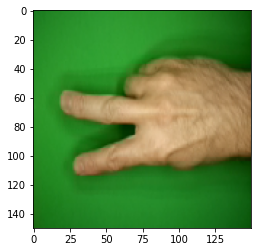

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  # print(classes)
  # print(train_generator.class_indices)
  
  print(fn)
  if classes[0,0]==1:
    print('Paper')
  elif classes[0,1]==1:
    print('Rock')
  elif classes[0,2]==1:
    print('Scissors')
  else:
    print("Coba Lagi")